# Semantic Segmentation of Water using U-Net
# Part 9 - Model Testing

In [1]:
%matplotlib inline
import os
import pandas as pd
import pickle
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from unetlib.metrics import BinaryMeanIoU
from unetlib.model import UNet_BN
from unetlib.preprocessing import make_dataframes_for_flow, make_img_msk_flows
import unetlib.visualisation as vs
from unetlib.callbacks import TrainingTimer

In [2]:
# Imagery directories
nwpu_data_dir = 'nwpu_lake_images/data/'
nwpu_mask_dir = 'nwpu_lake_images/masks/'

In [3]:
out_dir = 'model_outputs/'

## Retrain Model

Now that I've selected my best model I can test it to see how it performs on the unseen test data to get a final evaluation. I no longer have need for the validation set so I can now retrain the model using the full training set i.e. no validation split.

This *should* help with model generalisation as it will be trained on more images.

In [4]:
def compile_model(model, optimiser, lr=None):
    """Convenience function to compile model
    
    """
    # configure optimiser
    if isinstance(optimiser, str):
        optimiser = tf.keras.optimizers.get(optimiser)
        if lr is not None:
            optimiser.lr = lr

    # Compile model
    model.compile(optimizer=optimiser,
                  loss='binary_crossentropy',
                  metrics=[BinaryMeanIoU(threshold=0.5,name='binary_mean_iou')]
                  )

In [ ]:
# Create and train model with no validation set
opt = 'RMSProp'
lr = 0.01
batch_size = 32

# Split the test/train data
(train_img_df, train_msk_df,
 test_img_df, test_msk_df) = make_dataframes_for_flow(nwpu_data_dir,
                                                      nwpu_mask_dir,
                                                      test_size=0.25,
                                                      random_state=42
                                                      )

model = UNet_BN(n_filters=64, n_blocks=4, bn_pos='before', model_name='final')
compile_model(model, opt, lr)

# Generate filename for output files
base_fn = os.path.join(out_dir, f"final_model_{{}}")


## Configure callbacks
# Checkpointer - set to monitor `loss` since no `val_loss` is calculated
checkpointer = tf.keras.callbacks.ModelCheckpoint(base_fn.format('.weights.h5'),
                                                  monitor='loss',
                                                  save_best_only=True,
                                                  save_weights_only=True
                                                  )

# Timer
timer = TrainingTimer()

callbacks=[checkpointer, timer]

# Same augmentations as used previously
aug_dict = {'rotation_range': 90,
            'horizontal_flip': True,
            'vertical_flip': True,
            'width_shift_range': 0.15,
            'height_shift_range': 0.15,
            'zoom_range': 0.25
            }

# Set `val_split=0` to use all the training images
(train_gen, train_fps) = make_img_msk_flows(train_img_df, train_msk_df,
                                            nwpu_data_dir, nwpu_mask_dir,
                                            val_split=0, rescale=1 / 255.,
                                            aug_dict=aug_dict,
                                            batch_size=batch_size
                                           )

# Compute steps per epoch
train_steps = int(np.ceil(len(train_fps) / batch_size))


# Train the model
# Since there is no validation data to use for early stopping I will use
# the number of epochs that gave the best loss for this model configuration
# in the previous part.
history = model.fit(train_gen, epochs=268, steps_per_epoch=train_steps,
                    callbacks=callbacks
                   )

# Save history to pickle
    with open(base_fn.format('.history.pickle'), 'wb') as f:
        pickle.dump(history.history, f)

Found 300 validated image filenames.
Found 300 validated image filenames.
Epoch 1/268
10/10 [==============================] - 31s 2s/step - loss: 0.7532 - binary_mean_iou: 0.4201
Epoch 2/268
10/10 [==============================] - 10s 1s/step - loss: 0.3039 - binary_mean_iou: 0.6940
Epoch 3/268
10/10 [==============================] - 10s 1s/step - loss: 0.2293 - binary_mean_iou: 0.7525
Epoch 4/268
10/10 [==============================] - 10s 1s/step - loss: 0.2541 - binary_mean_iou: 0.7185
Epoch 5/268
10/10 [==============================] - 10s 1s/step - loss: 0.2394 - binary_mean_iou: 0.7504
Epoch 6/268
10/10 [==============================] - 10s 1s/step - loss: 0.2061 - binary_mean_iou: 0.7783
Epoch 7/268
10/10 [==============================] - 10s 1s/step - loss: 0.2195 - binary_mean_iou: 0.7706
Epoch 8/268
10/10 [==============================] - 10s 1s/step - loss: 0.2190 - binary_mean_iou: 0.7671
Epoch 9/268
10/10 [==============================] - 10s 1s/step - loss: 0.211

10/10 [==============================] - 10s 1s/step - loss: 0.0717 - binary_mean_iou: 0.9161
Epoch 153/268
10/10 [==============================] - 10s 1s/step - loss: 0.0735 - binary_mean_iou: 0.9170
Epoch 154/268
10/10 [==============================] - 10s 1s/step - loss: 0.0740 - binary_mean_iou: 0.9145
Epoch 155/268
10/10 [==============================] - 10s 1s/step - loss: 0.0708 - binary_mean_iou: 0.9182
Epoch 156/268
10/10 [==============================] - 10s 1s/step - loss: 0.0785 - binary_mean_iou: 0.9107
Epoch 157/268
10/10 [==============================] - 10s 1s/step - loss: 0.0696 - binary_mean_iou: 0.9184
Epoch 158/268
10/10 [==============================] - 10s 1s/step - loss: 0.0744 - binary_mean_iou: 0.9162
Epoch 159/268
10/10 [==============================] - 10s 1s/step - loss: 0.0659 - binary_mean_iou: 0.9229
Epoch 160/268
10/10 [==============================] - 10s 1s/step - loss: 0.0661 - binary_mean_iou: 0.9218
Epoch 161/268
10/10 [=====================

Epoch 228/268
10/10 [==============================] - 10s 1s/step - loss: 0.0608 - binary_mean_iou: 0.9266
Epoch 229/268
10/10 [==============================] - 10s 1s/step - loss: 0.0675 - binary_mean_iou: 0.9209
Epoch 230/268
10/10 [==============================] - 10s 1s/step - loss: 0.0587 - binary_mean_iou: 0.9310
Epoch 231/268
10/10 [==============================] - 10s 1s/step - loss: 0.0628 - binary_mean_iou: 0.9252
Epoch 232/268
10/10 [==============================] - 10s 1s/step - loss: 0.0607 - binary_mean_iou: 0.9254
Epoch 233/268
10/10 [==============================] - 10s 1s/step - loss: 0.0594 - binary_mean_iou: 0.9279
Epoch 234/268
10/10 [==============================] - 10s 1s/step - loss: 0.0595 - binary_mean_iou: 0.9270
Epoch 235/268
10/10 [==============================] - 10s 1s/step - loss: 0.0620 - binary_mean_iou: 0.9240
Epoch 236/268
10/10 [==============================] - 10s 1s/step - loss: 0.0701 - binary_mean_iou: 0.9197
Epoch 237/268
10/10 [=======

In [ ]:
timer.runtime_seconds()

2828.8283956050873

In [ ]:
with open('./model_outputs/final_model_.history.pickle', 'rb') as p:
    history = pickle.load(p)

In [ ]:
hist_df = pd.DataFrame(history)
hist_df

,loss,binary_mean_iou
0,0.598175,0.506592
1,0.333648,0.668052
2,0.226710,0.757480
3,0.272236,0.717151
4,0.218921,0.769536
...,...,...
263,0.053432,0.937382
264,0.050691,0.938231
265,0.052918,0.935901
266,0.053361,0.937372


<AxesSubplot:>

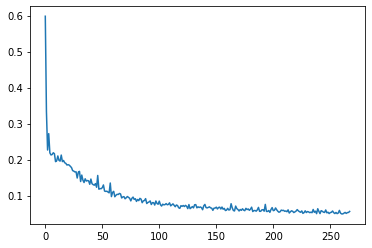

In [ ]:
hist_df.loss.plot()

<AxesSubplot:>

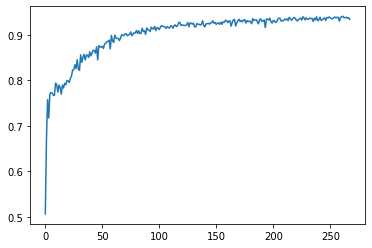

In [ ]:
hist_df.binary_mean_iou.plot()

# Prepare Test Data

In [5]:
# Need to run this step if model not trained in this session
# Split the test/train data
(train_img_df, train_msk_df,
 test_img_df, test_msk_df) = make_dataframes_for_flow(nwpu_data_dir,
                                                      nwpu_mask_dir,
                                                      test_size=0.25,
                                                      random_state=42
                                                      )

In [6]:
(test_gen, test_fps) = make_img_msk_flows(test_img_df, test_msk_df,
                                            nwpu_data_dir, nwpu_mask_dir,
                                            val_split=0, rescale=1 / 255.,
                                            batch_size=32
                                           )

Found 100 validated image filenames.
Found 100 validated image filenames.


## Evaluate on Test Data

In [7]:
# load model weights if required
opt = 'RMSProp'
lr = 0.01
model = UNet_BN(n_filters=64, n_blocks=4, bn_pos='before', model_name='final')
compile_model(model, opt, lr)
model.load_weights('model_outputs/final_model_.weights.h5')

In [8]:
model.metrics

[]

In [9]:
# The evaluate method can accept the (img, mask) generator
# and compute the compiled metrics over the batch
metrics = model.evaluate(test_gen, steps=3)
metrics

3/3 [==============================] - 9s 342ms/step - loss: 0.0799 - binary_mean_iou: 0.9265


[0.09962306171655655, 0.9187954068183899]

To calculate the BinaryMeanIoU for each image I can use the `model.predict` method.

In [10]:
model.metrics

In [13]:
# To predict i need a generator that only yields the test images
# i.e. not the masks.

# Instantiate new data generator.
# Need to include rescale argument so test images are same scale
# expected by the model
datagen = ImageDataGenerator(rescale=1/255.)

# Create the test image generator
test_img_gen = datagen.flow_from_dataframe(test_img_df,
                                            nwpu_data_dir,
                                            y_col=None,
                                            class_mode=None,
                                            shuffle=None,
                                            batch_size=32
                                           )

# Also create test mask generator to measure performance
test_msk_gen = datagen.flow_from_dataframe(test_msk_df,
                                           nwpu_mask_dir,
                                           y_col=None,
                                           class_mode=None,
                                           color_mode='grayscale',
                                           shuffle=None,
                                           batch_size=32
                                           )

Found 100 validated image filenames.
Found 100 validated image filenames.


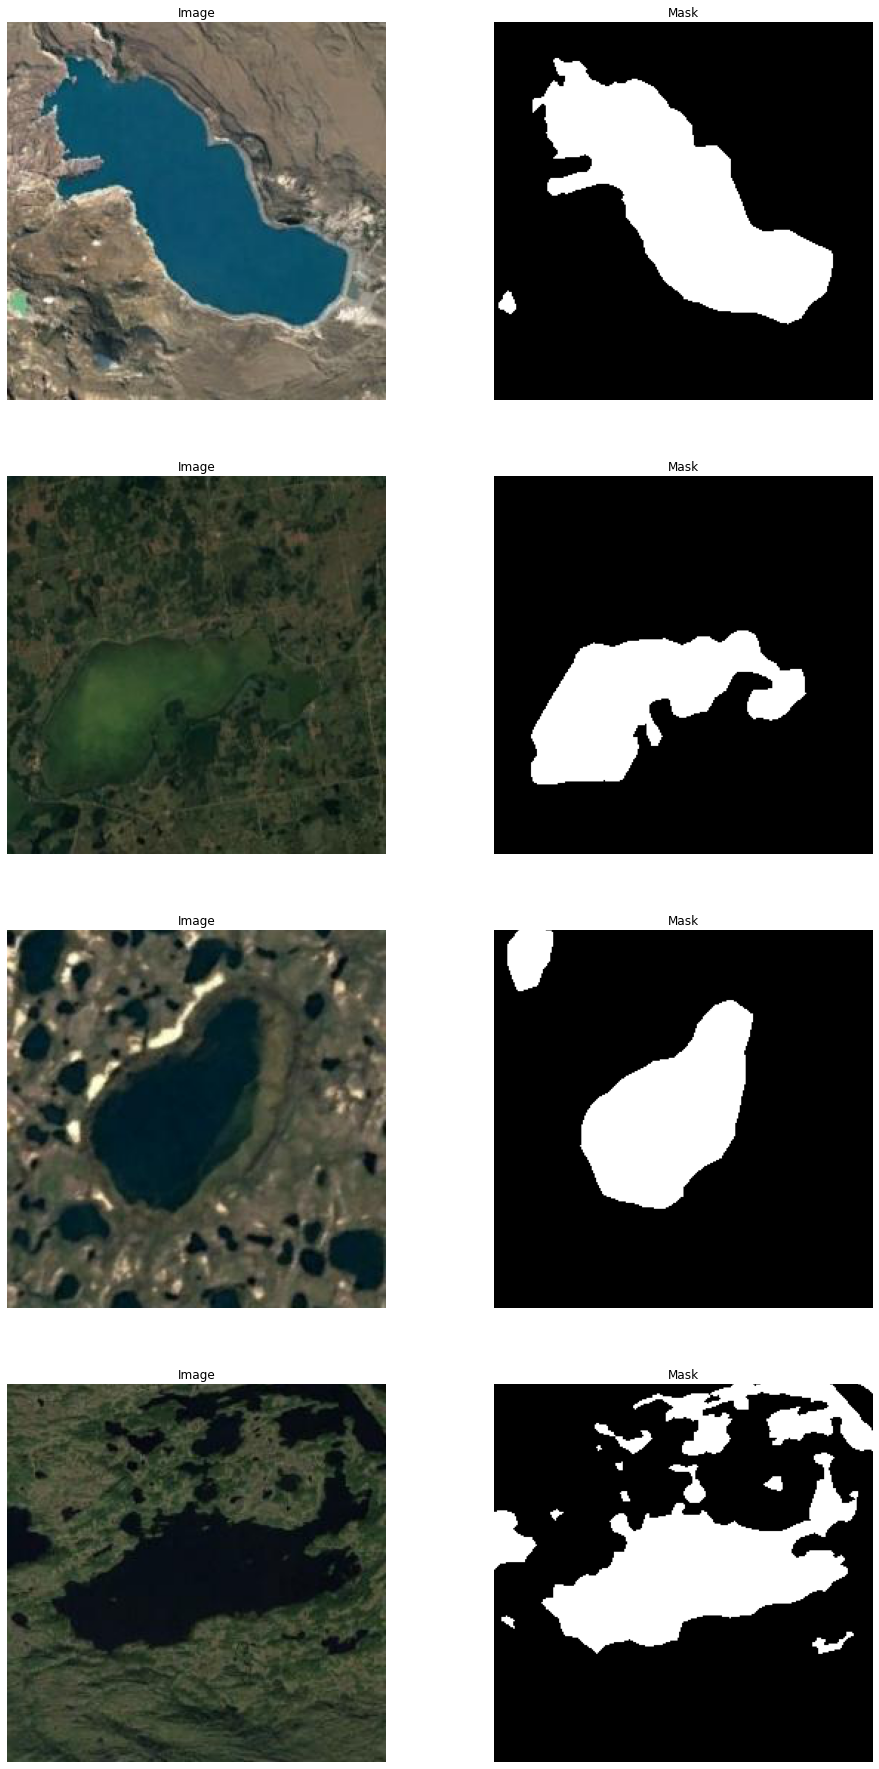

In [12]:
# Check images and masks are aligned
test_img_batch = next(test_img_gen)
test_msk_batch = next(test_msk_gen)

vs.plot_batch(test_img_batch, test_msk_batch, n_images=4, figsize=(16,32))

In [14]:
# IMPORTANT - First rerun the generator inisialisation!

processed = 0
binary_mean_ious = np.empty((0))
bmiou_threshold = model.metrics[1].threshold # same threshold used by model (0.5 in this case)
bmiou=BinaryMeanIoU(bmiou_threshold) 

imgs = np.empty((0, 256, 256, 3), dtype=np.float32)
msks = np.empty((0, 256, 256, 1), dtype=np.float32)
preds = np.empty((0, 256, 256, 1), dtype=np.float32)

while processed < 100:
    batch_img = next(test_img_gen)
    batch_msk = next(test_msk_gen)
    batch_preds = model.predict(batch_img)
    imgs = np.append(imgs, batch_img, axis=0)
    msks = np.append(msks, batch_msk, axis=0)
    preds = np.append(preds, batch_preds, axis=0)
    
    for y_true, y_pred in zip(batch_msk, batch_preds):
        # Compute the Binary mean IoU
        # Recall that this applies a threshold to the floating point
        # predictions
        bmiou.update_state(tf.convert_to_tensor(y_true), tf.convert_to_tensor(y_pred))
        binary_mean_ious = np.append(binary_mean_ious, bmiou.result().numpy())
        bmiou.reset_states()
    
    processed += batch_img.shape[0]

In [15]:
binary_mean_ious

array([0.97848135, 0.84884429, 0.73797512, 0.93343782, 0.86171663,
       0.95847589, 0.96012181, 0.94066763, 0.97124738, 0.89320099,
       0.96122408, 0.97385991, 0.82439041, 0.88637829, 0.87118435,
       0.94711912, 0.96476978, 0.94675934, 0.96645796, 0.97838175,
       0.88860977, 0.95614141, 0.97431004, 0.81522024, 0.96358657,
       0.97381032, 0.95184624, 0.9782784 , 0.94456553, 0.85459697,
       0.93229461, 0.96435916, 0.94739485, 0.97542411, 0.91506684,
       0.92585969, 0.89433658, 0.95855194, 0.90352702, 0.97596467,
       0.97022843, 0.84483659, 0.91344982, 0.93579102, 0.8854351 ,
       0.9745065 , 0.94381195, 0.91981834, 0.97419226, 0.89324772,
       0.96349931, 0.96778589, 0.96240783, 0.90603447, 0.96783322,
       0.97401524, 0.94669694, 0.97790229, 0.89296043, 0.86926317,
       0.96539783, 0.97172892, 0.93831527, 0.94456327, 0.87527901,
       0.77198976, 0.97244751, 0.92692089, 0.3478241 , 0.96999484,
       0.837973  , 0.95249486, 0.97613311, 0.90783095, 0.36375

In [16]:
print(f"Lowest IoU: {binary_mean_ious.min():.6f}")
print(f"Highest IoU: {binary_mean_ious.max():.6f}")
print(f"Mean IoU: {binary_mean_ious.mean():.6f}")
print(f"Std IoU: {binary_mean_ious.std():.6f}")

Lowest IoU: 0.347824
Highest IoU: 0.985421
Mean IoU: 0.918028
Std IoU: 0.093642


## Visualise Predictions
Visualising the predictions along with the original images and masks can help idenify sources of potential error.

In [17]:
# preds are floating point values so threshold must be applied
preds_t = tf.keras.backend.cast(preds > bmiou_threshold, np.int8).numpy()
print(type(preds_t),preds_t.shape, preds_t.dtype)

<class 'numpy.ndarray'> (100, 256, 256, 1) int8


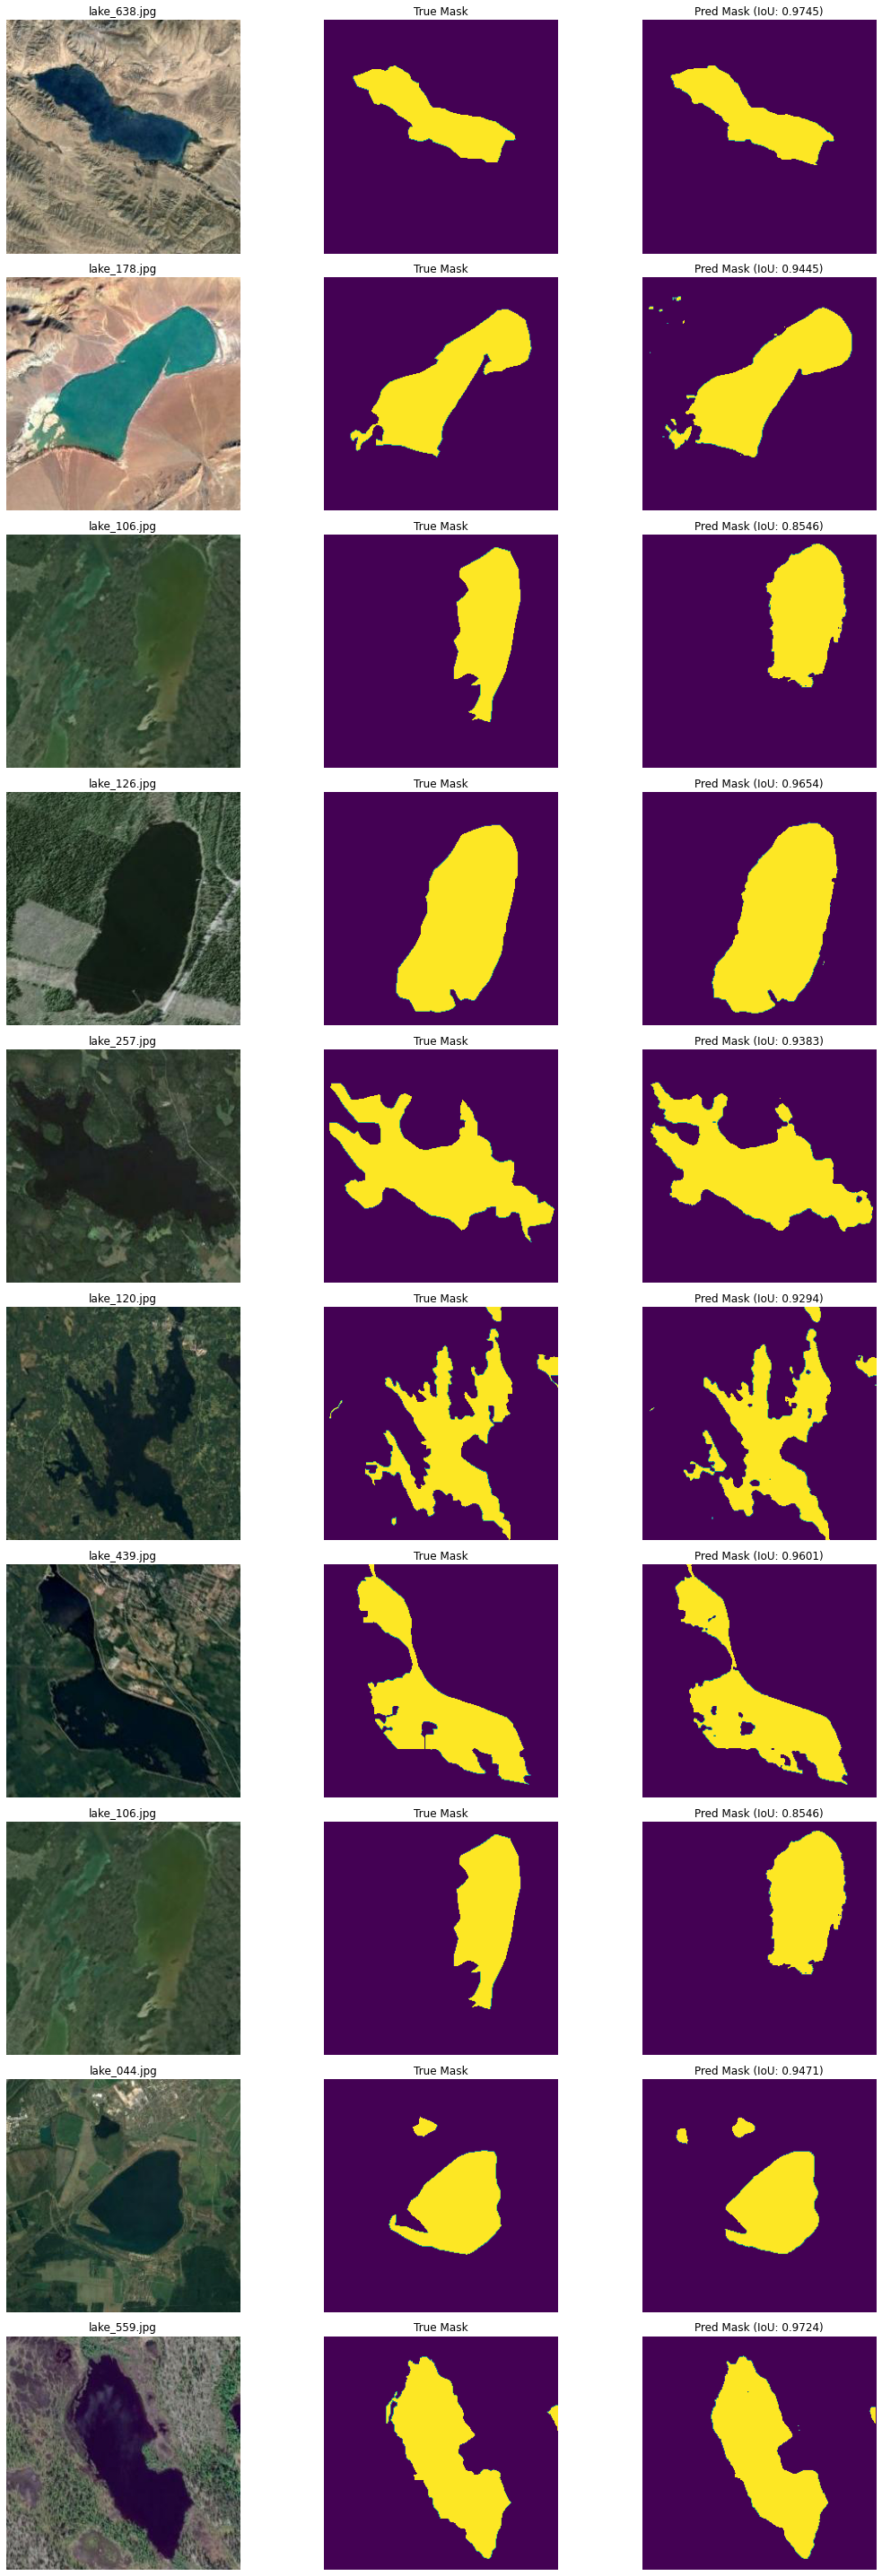

In [18]:
# plot random selection of test imgs, msks and preds
num_imgs = 10
img_idxs = np.random.choice(range(100), num_imgs)
plot_imgs = imgs[img_idxs]
plot_msks = msks[img_idxs]
plot_preds = preds_t[img_idxs]
plot_iou = binary_mean_ious[img_idxs]
plot_fps = np.array(test_img_gen.filepaths)[img_idxs]

fig, axes = plt.subplots(num_imgs, 3, figsize=(16, 4*num_imgs))

for i, plot_data in enumerate(zip(plot_imgs, plot_msks, plot_preds,
                                  plot_iou, plot_fps)
                             ):
    row_ax = axes[i]
    titles = [f'{os.path.basename(plot_data[-1])}', 'True Mask',
              f'Pred Mask (IoU: {plot_data[-2]:.4f})']
    
    for ax, im, title in zip(row_ax, plot_data[:-2], titles):
        ax.imshow(im)
        ax.set_title(title)
        ax.axis('off')
        
fig.tight_layout()

The predictions match up pretty nicely with the true labels. There are certainly some errors, for example cases where forest or shadow is classified as water, the ommission or partial classification of smaller water bodies etc.

The threshold for classification (0.5 currently) can also be tuned. If the threshold is lowered then some of the partial or missing water bodies may be correctly classified, at the expense of non-water pixels being misclassified. If the threshold is increased then some of the pixels currenly classified as water will be removed. There is a balance to strike here but care must be taken - tuning the threshold should be carried out on the **validation data** not this test data!

Another interesting observation is that it is clear how my manual labelling has effected the segmentation and overall performance. In some images I have missed water bodies. Additionally, the tool I used to label the images did not allow for polygons with holes. As a result, for land masses within a water bodies I either ignored them or crudely drew around them then back to the edge of the main water body - leaving a sliver of non-water pixels which should be water.

In some cases where I have missed water in the true label, the model has actually classified it correctly (eg. ). However, the resulting IoU will be penalised since it doesnt match the "true" label.

Likewise, the model has been able to classify islands as non-water in cases there they are water in the "true" label. Again the IoU is penalised.

This demonstrates the importance of accurate labels. Further work here would be for me to revisit the labelling to ensure it is complete and accurate.

## Wrapping Up

Within these notebooks I have demonstrated how to build a neural network using the U-Net architecture to tackle the a semantic segmentation challenge. I have shown how to process imagery and labels into a dataset for training and evaluating model performance. I explored how to create custom metrics and callbacks and I have shown how to use data augmentation techniques to expand the data and improve model performance. I evaluated different model architectures and tuned hyperparamaters to arrive at my final model. I was able to achieve an accuracy (Mean IoU) of 91.9% on data the model had not previously seen.

Overall, I managed to achieve good performance using a small dataset (samples) and low level of information (just R,G,B). As discussed, however, my manually-created labels need to be improved!

## Other Ideas

- Label more images
    - Increasing the size of the dataset should lead to improved performance and generalisation
- Improve labels using conditional random fields
    - See 
- Try cross-validation
    - Instead of splitting a third of the training set into a validation set, I could use cross validation with the entire training set maximise the use of the small amount of data.
- Evaluate different rescaling options
    - Throughout this process I simply scaled by 1/255. Would standardisation work better?
- Evaluate different activation functions
    - I could explore the use of tanh for example. Note that this may require me to adjust use of batchnorm appropriately)
- Evaluate different weights initialisations
    - He
- Experiment with weight regularisation
    - L1 / L2
- Evaluate different loss functions
    - For example I could use Dice Loss
- Change model selection criteria
    - Here I focused on minimising the validation loss. However, there are by val_binary_mean_iou as opposed to val_loss?
- Change the architecture further
    - Deeper/wider network with dropout
    - I could really increae
- Ensemble
    - Train several small/simpler models and average the outputs.